In [ ]:
#!pip install pydub tensorflow_io
import tensorflow_datasets as tfds
!pip install pydub

In [ ]:


(dataset_train_original, dataset_validate_original), info = tfds.load(
    'spoken_digit',
    split=['train[:80%]','train[80%:]'],
    with_info=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/spoken_digit/1.0.9.incompleteQYFBSA/spoken_digit-train.tfrecord


  0%|          | 0/2500 [00:00<?, ? examples/s]

Dataset spoken_digit downloaded and prepared to /root/tensorflow_datasets/spoken_digit/1.0.9. Subsequent calls will reuse this data.


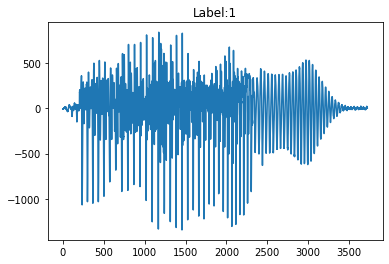

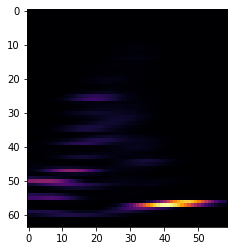

(64, 59)


In [ ]:
import matplotlib.pyplot as plt
from IPython.display import display, Audio
import librosa #feature extraction os audio data
import numpy as np

for sample in dataset_train_original.shuffle(10).take(1):
  audio = sample['audio']
  label = sample['label']

  plt.plot(audio)
  plt.title(f'Label:{label}')
  plt.show()

  display(Audio(audio, rate=8000))

  mel = librosa.feature.melspectrogram(
      

      y=audio.numpy().astype('float32'), n_mels=64, hop_length=64, sr=8000, fmax=2000
  )

  mel /= np.max(mel)
  plt.imshow(mel[::-1, :], cmap='inferno') # inverting tge grph
  plt.show()
  print(mel.shape)

     |████████████████████████████████| 22.7 MB 1.9 MB/s 


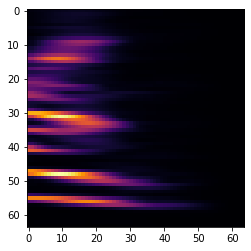

In [ ]:
import tensorflow as tf
!pip install tensorflow_io
import tensorflow_io as tfio

def preprocess (sample):

  #splitting image and label
  audio = sample['audio']
  label = sample['label']

  #float
  audio = tf.cast(audio, tf.float32)/32768.0 #maximun number expected

  #Feature extraction.Mel.
  spectrogram = tfio.audio.spectrogram(
      
      audio, nfft=1024, window=1024, stride=64
  )

  spectrogram = tfio.audio.melscale(
      
      spectrogram, rate=8000, mels=64, fmin=0, fmax=2000
  )
  #make it a picture
  spectrogram = tf.expand_dims(spectrogram, axis=-1)
   #Same shape
  spectrogram = tf.image.resize(spectrogram, (64,64))
  #Not necesary
  spectrogram = tf.transpose(spectrogram, perm=(1,0,2))
  spectrogram = spectrogram[::-1,:,:] #everything with first axis rotated
  #Normalization.
  spectrogram /= tf.math.reduce_max(spectrogram)
 

  return spectrogram, label

dataset = dataset_train_original.map(lambda sample: preprocess(sample))

for x, y in dataset.shuffle(23).take(1):
  x = x.numpy()
  plt.imshow(x[:, :, 0], cmap='inferno', vmin=0, vmax=1.0)
  plt.show()
  plt.close()

In [ ]:
#CNN
dataset_train = dataset_train_original.map(lambda sample: preprocess(sample)).cache().shuffle(2500).batch(32)

dataset_validate = dataset_validate_original.map(lambda sample: preprocess(sample)).cache().shuffle(2500).batch(32)

history_dictionary = {}

In [ ]:
from tensorflow.keras import models, layers
model = models.Sequential()
    
model.add(layers.Input(shape=(64,64,1)))

model.add(layers.Conv2D(4, (3,3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Conv2D(8, (3,3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Conv2D(8, (3,3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Conv2D(16, (3,3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2,2)))   
   
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

model.summary()


model.compile(
    
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    dataset_train,
    epochs=45,
    validation_data = dataset_validate

)


history_dictionary['first'] = history.history

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 64, 64, 4)         40        
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 32, 32, 4)        0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 32, 32, 8)         296       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 16, 16, 8)        0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 16, 16, 8)         584       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 8, 8, 8)         

In [ ]:
def render_history(history):
    plt.plot(history["loss"], label="loss")
    plt.plot(history["val_loss"], label="val_loss")
    plt.legend()
    plt.title("Our losses")
    plt.show()
    plt.close()

    plt.plot(history["accuracy"], label="accuracy")
    plt.plot(history["val_accuracy"], label="val_accuracy")
    plt.legend()
    plt.title("Our accuracies")
    plt.show()
    plt.close()


def compare_histories():
    for training_name, history in history_dictionary.items():
        plt.plot(history["val_accuracy"], label=training_name)
    plt.legend()
    plt.title("Comparision of val_accuracy")
    plt.show()
    plt.close()



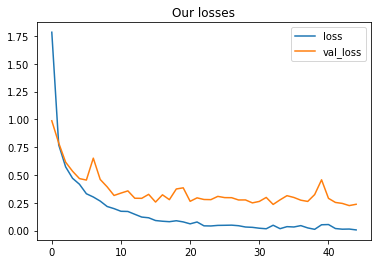

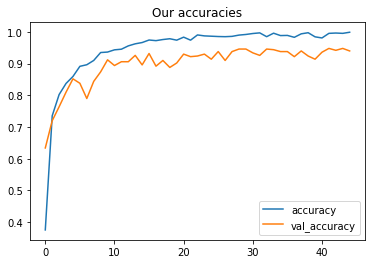

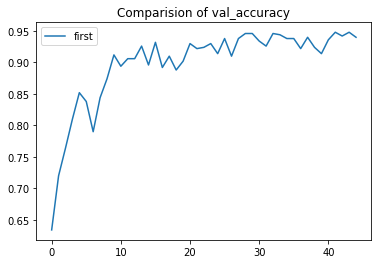

In [ ]:
render_history(history.history)
compare_histories()